# Import data functions

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf


In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.preprocessing import (
    StandardScaler,
)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data_files(data_dir='/content/drive/MyDrive/training-validation'):
    source_files = glob.glob(pathname=data_dir + '/**/*.csv')
    return source_files

def create_dataset(source_files):
    dataset_csv = pd.concat([
        pd.read_csv(file,header=None,names=['Id','Heart_rate','Respiratory_rate','Oxygen_saturation','Baby_status'])
        for file in source_files
    ],ignore_index=True)
    return dataset_csv

def files_preprocessing(data_dir='training-validation'):
    source_files = glob.glob(pathname=data_dir + '/**/*.csv')
    for index,file in enumerate(source_files):
        if index == 0:
            df = pd.read_csv(file,header=None,names=['Id','Heart_rate','Respiratory_rate','Oxygen_saturation','Baby_status'])
            break
    return df

# Data preprocessing

In [ ]:
def transform_dataset(dataset):
    # remove the first col in place
    dataset = dataset.drop('Id', inplace=False, axis=1)
    # remove samples without target value
    dataset = dataset[(dataset['Baby_status'] == 0) | (dataset['Baby_status'] == 1) | (dataset['Baby_status'] == 2)]
    # data clean
    dataset = dataset.replace('--1',-1)
    return dataset
    

def standard_scaler(dataset):
    scaler = StandardScaler()
    dataset = dataset.reshape(-1,3)
    scaled_dataset = scaler.fit_transform(dataset)
    return (scaled_dataset.reshape(-1,31,3),scaler)


def csv_file_processing(df):
    df = transform_dataset(dataset=df)
    X = df[['Heart_rate','Respiratory_rate','Oxygen_saturation']].to_numpy()
    y = df['Baby_status'].to_numpy()
    if X.shape[0] == 31:
        return (X.reshape(1,31,-1),y.reshape(1,-1))                                            


def build_dataset(source_files):
    X = np.empty(shape=(1,31,3))
    Y = np.empty(shape=(1,1))
    for index,file in enumerate(source_files):
        df = pd.read_csv(file,header=None,names=['Id','Heart_rate','Respiratory_rate','Oxygen_saturation','Baby_status'])
        data = csv_file_processing(df)
        if data:
            x = data[0]
            y = data[1]
            if x.shape[2] == 3:
                X = np.vstack((X,x))
                Y = np.vstack((Y,y[0,-1])) # the target value if the 31th row
                # print()
    return (np.delete(X, 0,axis=0),np.delete(Y, 0,axis=0))

# Utils functions for plotting charts

In [ ]:

def plot_training_results(model_history,epochs,fig_name=None):
    x = np.linspace(start=1,stop=epochs,num=epochs)
    plt.figure(figsize=(13,13))
    plt.plot(x,
             model_history.get('loss'),
             color='red',
             marker='o',
             linestyle='dashed',
             linewidth=2,
             markersize=9,
             label= f'Training loss: Final accuracy = {model_history.get("accuracy")[-1]:.2f}'
             )
    plt.plot(x,
             model_history.get('val_loss'),
             color='green',
             marker='o',
             linewidth=2,
             markersize=9,
             label= f'Training loss: Final accuracy = {model_history.get("val_accuracy")[-1]:.2f}'
            )
    
    plt.title(f'Training_validation results: {fig_name}', fontdict={
        'fontsize': 12,
        'fontweight': 2
        },
        pad=9
    )
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Model Losses')
    plt.legend()
    plt.savefig('unamed_figure' if fig_name is None else fig_name)

# Model architecture

In [ ]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Flatten
from keras.layers import (
    Dense,
    LSTM,
)
def create_lstm(layer_number=5,
               lstm_cells_per_layer=20,
               output_shape=3,
               dropout=0):
  
  model = Sequential()
  model.add(tf.keras.layers.RNN(tfa.rnn.PeepholeLSTMCell(lstm_cells_per_layer), return_sequences=True,input_shape=(31,3)))
  for layer_n in range(layer_number):
    if layer_n == 0:
      model.add(LSTM(units=lstm_cells_per_layer,return_sequences=True)) 
    # elif layer_n == layer_number - 1:
    #   model.add(LSTM(units=lstm_cells_per_layer))
    # elif layer_n==2:
    #   model.add(tf.keras.layers.RNN(tfa.rnn.PeepholeLSTMCell(lstm_cells_per_layer), return_sequences=True))
    else:
      model.add(LSTM(units=lstm_cells_per_layer,
                    return_sequences= True,
                    #kernel_regularizer= regularizers.L2(l2=0.003),
                    #bias_regularizer= regularizers.L2(l2=0.003),
                    recurrent_dropout=dropout,
                    dropout=dropout))
  model.add(Flatten())
  model.add(Dense(units=40))
  model.add(Dense(units=10))
  model.add(Dense(units=output_shape,activation='softmax'))
  return model

# Train function

In [ ]:

def train(model,
          train_dataset,
          validation_dataset,
          epochs = 20,
          batch_size = 31,
          save_after_train = False
          ):
    
    X_train,Y_train = train_dataset
    X_validation,y_validation = validation_dataset

    history = model.fit(
    x= X_train,
    y= Y_train,
    batch_size= batch_size,
    epochs= epochs,
    validation_data= (X_validation, y_validation)
    )

    if save_after_train:
        model.save('my_model_pt2',save_format='h5')

    return history,model


# Train script

564


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, 31, 20)            1980      
                                                                 
 lstm (LSTM)                 (None, 31, 20)            3280      
                                                                 
 lstm_1 (LSTM)               (None, 31, 20)            3280      
                                                                 
 lstm_2 (LSTM)               (None, 31, 20)            3280      
                                                                 
 lstm_3 (LSTM)               (None, 31, 20)            3280      
                                                                 
 lstm_4 (LSTM)               (None, 31, 20)            3280      
                                                                 
 flatten (Flatten)           (None, 620)               0

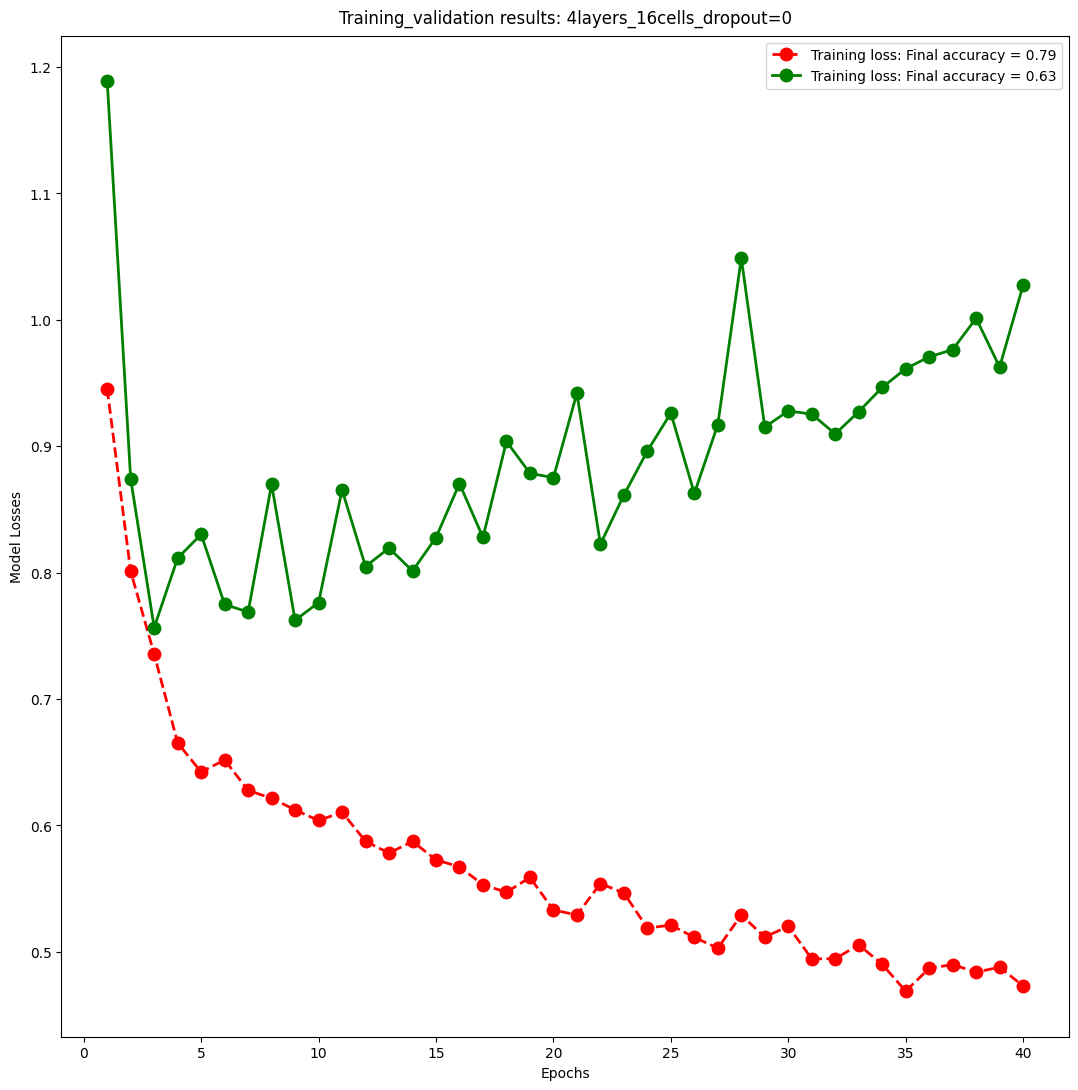

In [ ]:
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import Accuracy

# Data import and Preprocessing
dataset = build_dataset(source_files=load_data_files())
print(len(dataset[0]))
X_train, X_validation, Y_train, Y_validation = train_test_split(dataset[0], dataset[1], test_size=0.18, random_state=42)

X_train, _ = standard_scaler(dataset=X_train)
X_validation, _ = standard_scaler(dataset=X_validation)

# Create model
model = create_lstm()
model.summary()
# Hyperparameters
learning_rate = 0.003
batch_size = 25
epochs = 40
optimizer = Adam()
loss = SparseCategoricalCrossentropy()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

# Model training
hist, model = train(
    model=model,
    train_dataset=(X_train, Y_train),
    validation_dataset=(X_validation, Y_validation),
    epochs=epochs,
    batch_size=batch_size,
    save_after_train=True  # save the trained model to H5 file
)

# show results
plot_training_results(model_history=hist.history,
                      epochs=epochs, fig_name="4layers_16cells_dropout=0")


# Test script

In [ ]:
pip install tensorflow-addons

In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from sklearn.preprocessing import (
    StandardScaler,
)
from keras.models import Sequential
from keras import regularizers
from keras.layers import (
    Dense,
    LSTM,
)
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import Accuracy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
def build_dataset(source_files):
    X = np.empty(shape=(1,31,3))
    Y = np.empty(shape=(1,1))
    for index,file in enumerate(source_files):
        df = pd.read_csv(file,header=None,names=['Id','Heart_rate','Respiratory_rate','Oxygen_saturation','Baby_status'])
        data = csv_file_processing(df)
        if data:
            x = data[0]
            y = data[1]
            if x.shape[2] == 3:
                X = np.vstack((X,x))
                Y = np.vstack((Y,y[0,-1])) # the target value if the 31th row
    return (np.delete(X, 0,axis=0),np.delete(Y, 0,axis=0))

def load_data_files(data_dir='/content/drive/MyDrive/training-validation'):
    source_files = glob.glob(pathname=data_dir + '/**/*.csv')
    return source_files

def csv_file_processing(df):
    df = transform_dataset(dataset=df)
    X = df[['Heart_rate','Respiratory_rate','Oxygen_saturation']].to_numpy()
    y = df['Baby_status'].to_numpy()
    if X.shape[0] == 31:
        return (X.reshape(1,31,-1),y.reshape(1,-1)) 

def transform_dataset(dataset):
    # remove the first col in place
    dataset = dataset.drop('Id', inplace=False, axis=1)
    # remove samples without target value
    dataset = dataset[(dataset['Baby_status'] == 0) | (dataset['Baby_status'] == 1) | (dataset['Baby_status'] == 2)]
    # data clean
    dataset = dataset[dataset['Oxygen_saturation'] != '--1']
    return dataset

def standard_scaler(dataset):
    scaler = StandardScaler()
    dataset = dataset.reshape(-1,3)
    scaled_dataset = scaler.fit_transform(dataset)
    return (scaled_dataset.reshape(-1,31,3),scaler)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import load_model

_LOAD_PATH = 'my_model_pt2'
TEST_DATASET_PATH = '/content/drive/MyDrive/testing' # To be changed I used this path for testing purposes

def evaluate_model(test_dataset,saved_model_path):

    X_test, Y_test = test_dataset

    model = load_model(saved_model_path)
    
    
    loss, acc = model.evaluate(X_test, Y_test, verbose=2)
    print("Restored model, accuracy: {:5.2f}% on test dataset".format(100 * acc))


X_test,Y_test = build_dataset(source_files=load_data_files(data_dir=TEST_DATASET_PATH))
X_test,_ = standard_scaler(dataset=X_test)
evaluate_model(test_dataset=(X_test,Y_test),saved_model_path=_LOAD_PATH)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


4/4 - 3s - loss: 0.9619 - accuracy: 0.6373 - 3s/epoch - 809ms/step
Restored model, accuracy: 63.73% on test dataset
